In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # not enough memory in GPU

import shutil
import matplotlib.pyplot as plt
from tensorboard.plugins.hparams import api as hp

from KAGGLE_NLP_with_disaster_tweets.model.simple_bert_model import SimpleBertModel
from KAGGLE_NLP_with_disaster_tweets.model import constants, utils
from KAGGLE_NLP_with_disaster_tweets.data_preparation.utils import DataPipeline, BatchPipeline

log_dir = './logs/hyperparameter_tuning_BertModel/'
 # clearing logging directory
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
else:
    os.makedirs(log_dir)

In [22]:
train_file_name = 'train.csv'
test_file_name = 'test.csv'
sample_submission_file_name = 'sample_submission.csv'
max_vocabulary_size = 20000

data_pipeline = DataPipeline(train_file_name, test_file_name, sample_submission_file_name,
                             output_sequence_length=30,
                             max_vocabulary_size=max_vocabulary_size,
                             glove_embedding_dim=300,
                             glove_url=constants.glove_url['6B'])
dataset = data_pipeline.prepare_train_dataset(include_cols=["location", "keyword"], extract_extras=True, download_mentioned_tweets=False, vectorize=False)

Getting the file: ../data/sample_submission.csv
Getting the file: ../data/train.csv
Dataframe size before eliminating too short texts: 7613
Dataframe size after eliminating too short texts: 7526
         id keyword location  \
0         1                    
1         4                    
2         5                    
3         6                    
4         7                    
...     ...     ...      ...   
7608  10869                    
7609  10870                    
7610  10871                    
7611  10872                    
7612  10873                    

                                                   text  target  
0     our deeds are the reason of this earthquake ma...       1  
1                 forest fire near la ronge sask canada       1  
2     all residents asked to shelter in place are be...       1  
3      people receive wildfires evacuation orders in...       1  
4     just got sent this photo from ruby alaska as s...       1  
...                     

In [23]:
balanced_class_weights = utils.get_balanced_class_weights(data_pipeline.dataframe)

In [24]:

batch_size = 64
epochs = 10
log_directory = "./logs/hyperparameter_tuning_BaseModel/"

# create a dict to keep the hyperparameters
hparams = {
    hp.HParam("optimizer", hp.Discrete(["adamw"])): "adamw",
    hp.HParam("batch_size", hp.Discrete([16, 32, 64])): batch_size,
    hp.HParam("learning_rate", hp.RealInterval(1e-5, 1e-3)): 1e-4,
    hp.HParam("class_weights", hp.Discrete(["none", "balanced"])): "balanced",
    hp.HParam("dropout", hp.Discrete([0.1, 0.9])): 0.5
}
# easier to manage hyperparameters with this wrapper class
hyperparameter_manager = utils.HyperparameterManager(hparams=hparams)

In [25]:
# with tf.summary.create_file_writer(log_directory).as_default():
#     hp.hparams_config(
#         hparams=hparams.keys(),
#         metrics=[hp.Metric("accuracy", display_name="Accuracy"),
#                  hp.Metric("precision", display_name="Precision"),
#                  hp.Metric("recall", display_name="Recall"),
#                  hp.Metric("f1", display_name="F1 Score")])

In [26]:
for input_, target_ in dataset.take(3):
    print(input_)

tf.Tensor(b'our deeds are the reason of this earthquake may allah forgive us all', shape=(), dtype=string)
tf.Tensor(b'forest fire near la ronge sask canada', shape=(), dtype=string)
tf.Tensor(b'all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected', shape=(), dtype=string)


In [27]:
# import tensorflow_text # required for Bert Model
bert_model = SimpleBertModel(batch_pipeline=BatchPipeline(dataset, batch_size),
                             hparam_manager=hyperparameter_manager,
                             num_classes=2,
                             epochs=epochs)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocess (KerasLayer)        {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [28]:
debugging_dataset = dataset.take(2).batch(2)
bert_model.test_model(debugging_dataset, 10)

Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.5727 - accuracy: 1.0000 - val_loss: 0.4339 - val_accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 0s 103ms/step - loss: 0.7138 - accuracy: 0.5000 - val_loss: 0.4328 - val_accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 111ms/step - loss: 0.8736 - accuracy: 0.0000e+00 - val_loss: 0.4304 - val_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 109ms/step - loss: 0.7066 - accuracy: 0.5000 - val_loss: 0.4270 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 113ms/step - loss: 0.7805 - accuracy: 0.5000 - val_loss: 0.4224 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 93ms/step - loss: 0.7573 - accuracy: 0.5000 - val_loss: 0.4171 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 98ms/step - loss: 0.3509 - accuracy: 1.0000 - val_loss: 0.4111 - val_accuracy: 1.0000
Epoch 8/10
1/1 [=====

In [29]:
accuracy, precision, recall, f1, predictions = bert_model.fit_and_evaluate(log_directory=log_directory, class_weights=balanced_class_weights)
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1-Score: {f1}")

run -> __lr=0.0001__batch_size=64__optimizer=adamw__class_weights=balanced__dropout=0.5 starting...
Epoch 1/10
70/70 [==============================] - ETA: 0s - loss: 0.8116 - accuracy: 0.5529

2022-03-08 15:40:30.194681: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 937635840 exceeds 10% of free system memory.


70/70 [==============================] - 36s 490ms/step - loss: 0.8116 - accuracy: 0.5529 - val_loss: 0.5585 - val_accuracy: 0.7561
Epoch 2/10
70/70 [==============================] - ETA: 0s - loss: 0.5699 - accuracy: 0.7388

2022-03-08 15:41:03.225427: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 937635840 exceeds 10% of free system memory.


70/70 [==============================] - 33s 471ms/step - loss: 0.5699 - accuracy: 0.7388 - val_loss: 0.4642 - val_accuracy: 0.7908
Epoch 3/10
70/70 [==============================] - ETA: 0s - loss: 0.4751 - accuracy: 0.8011

2022-03-08 15:41:38.008635: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 937635840 exceeds 10% of free system memory.


70/70 [==============================] - 35s 500ms/step - loss: 0.4751 - accuracy: 0.8011 - val_loss: 0.4506 - val_accuracy: 0.8091
Epoch 4/10
70/70 [==============================] - ETA: 0s - loss: 0.4262 - accuracy: 0.8257

2022-03-08 15:42:14.484254: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 937635840 exceeds 10% of free system memory.


70/70 [==============================] - 36s 521ms/step - loss: 0.4262 - accuracy: 0.8257 - val_loss: 0.4396 - val_accuracy: 0.8159
Epoch 5/10
70/70 [==============================] - ETA: 0s - loss: 0.3919 - accuracy: 0.8467

2022-03-08 15:42:52.144332: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 937635840 exceeds 10% of free system memory.


70/70 [==============================] - 38s 538ms/step - loss: 0.3919 - accuracy: 0.8467 - val_loss: 0.4465 - val_accuracy: 0.8227
Epoch 6/10
70/70 [==============================] - 35s 499ms/step - loss: 0.3608 - accuracy: 0.8574 - val_loss: 0.4615 - val_accuracy: 0.8274
Epoch 7/10
70/70 [==============================] - 35s 504ms/step - loss: 0.3406 - accuracy: 0.8710 - val_loss: 0.4636 - val_accuracy: 0.8281
Epoch 8/10
70/70 [==============================] - 35s 506ms/step - loss: 0.3183 - accuracy: 0.8790 - val_loss: 0.4618 - val_accuracy: 0.8308
Epoch 9/10
70/70 [==============================] - 36s 515ms/step - loss: 0.3098 - accuracy: 0.8871 - val_loss: 0.4627 - val_accuracy: 0.8295
Epoch 10/10
23/23 [==============================] - 3s 137ms/step - loss: 0.5213 - accuracy: 0.7887
run -> __lr=0.0001__batch_size=64__optimizer=adamw__class_weights=balanced__dropout=0.5 completed.
Accuracy: 0.788722813129425
Precision: 0.7877678571428571
Recall: 0.7870805938907415
F1-Score: 0

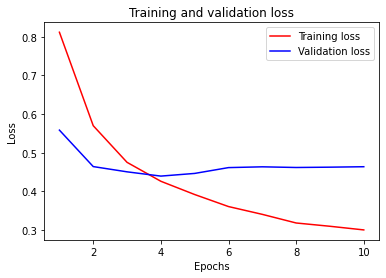

In [30]:
history_dict = bert_model.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

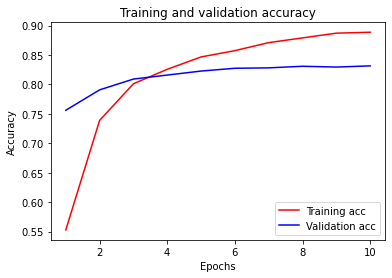

In [31]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [32]:
# %load_ext tensorboard

In [33]:
# tensorboard --logdir logs/hyperparameter_tuning_bertmodel --port 5001

Launching TensorBoard...